In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import json
import random
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
# from transformers import *
from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import pandas as pd
import string

In [4]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
d3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l3.csv')

d1_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')
d3_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l3.csv')


In [5]:
# # Verify GPU availability
# if not torch.cuda.is_available():
#     raise RuntimeError("GPU not available. Please enable GPU in your environment (e.g., Colab Runtime -> Change runtime type -> GPU).")
# print(f"Using GPU: {torch.cuda.get_device_name(0)}")

In [6]:
def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

d3['text'] = d3['text'].apply(lambda x: normalize_text(x))
d3_test['text'] = d3_test['text'].apply(lambda x: normalize_text(x))

In [7]:
d1.head()
d3.head()

,text,key,ta_a1,ta_a2,ta_a3,ta_a4,ta_a5,ta_a6
0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,question_3,NaN,NaN,0.0,0.0,0.0,0.0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,question_3,NaN,NaN,NaN,1.0,NaN,NaN
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,question_3,NaN,NaN,NaN,NaN,0.0,NaN
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்...,question_3,NaN,NaN,NaN,NaN,1.0,NaN
4,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...,question_3,1.0,NaN,NaN,NaN,NaN,NaN


In [8]:
X1 = list(d1['text'])
X1_test = list(d1_test['text'])
X3 = list(d3['text'])
X3_test = list(d3_test['text'])

col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')

    d3[col] = pd.to_numeric(d3[col], errors='coerce')
    d3_test[col] = pd.to_numeric(d3_test[col], errors='coerce')


d1['label_1'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label_1'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d3['label_3'] = d3[col_lst].max(axis=1, skipna=True).astype(int)
d3_test['label_3'] = d3_test[col_lst].max(axis=1, skipna=True).astype(int)


d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)
d3 = d3.drop(col_lst, axis=1)
d3_test = d3_test.drop(col_lst, axis=1)

d1['label_1'] = d1['label_1'].astype(int)
d1_test['label_1'] = d1_test['label_1'].astype(int)
d3['label_3'] = d3['label_3'].astype(int)
d3_test['label_3'] = d3_test['label_3'].astype(int)


d1 = d1[['label_1', 'text']]
d1_test = d1_test[['label_1', 'text']]
d1_test

d3 = d3[['label_3', 'text']]
d3_test = d3_test[['label_3', 'text']]
d3_test

,label_3,text
0,0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...
1,1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...
2,1,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...
3,0,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...
4,1,bachelor :face_with_steam_from_nose::face_wit...
...,...,...
1130,1,:face_with_tears_of_joy::face_with_tears_of_jo...
1131,1,:grinning_face_with_smiling_eyes: தமிழ் தெரிஞ்...
1132,1,:grinning_face_with_sweat::grinning_face_with_...
1133,1,:grinning_cat::pencil: — ஆமாம் வேச ஆமாம் வேச அ...


In [9]:
dn = pd.concat([d1, d3.drop(columns=['text'])], axis=1)
dn_test = pd.concat([d1_test, d3_test.drop(columns=['text'])], axis=1)

dn = dn[['text', 'label_1', 'label_3']]
dn_test = dn_test[['text', 'label_1', 'label_3']]
dn_test

,text,label_1,label_3
0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...,0,0
1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...,1,1
2,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...,0,1
3,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...,0,0
4,bachelor :face_with_steam_from_nose::face_wit...,1,1
...,...,...,...
1130,:face_with_tears_of_joy::face_with_tears_of_jo...,1,1
1131,:grinning_face_with_smiling_eyes: தமிழ் தெரிஞ்...,1,1
1132,:grinning_face_with_sweat::grinning_face_with_...,1,1
1133,:grinning_cat::pencil: — ஆமாம் வேச ஆமாம் வேச அ...,1,1


In [10]:
# Create new label column based on logic
def assign_label(row):
    label_1 = row['label_1']
    label_3 = row['label_3']

    # Handle NaN cases (rows with only label_1 or label_3)
    if pd.isna(label_1) and pd.isna(label_3):
        return np.nan  # Both missing
    elif pd.isna(label_1):
        # Only label_3 exists (from d3, d3_test)
        return 1 if label_3 == 1 else 0  # Treat as binary
    elif pd.isna(label_3):
        # Only label_1 exists (from d1, d1_test)
        return 2 if label_1 == 1 else 0  # Treat as binary
    else:
        # Both labels exist (unlikely unless datasets overlap)
        if label_1 == 0 and label_3 == 0:
            return 0
        elif label_1 == 0 and label_3 == 1:
            return 1
        elif label_1 == 1 and label_3 == 0:
            return 2
        else:  # label_1 == 1 and label_3 == 1
            return 3

# dn_new=dn.copy()
dn['label'] = dn.apply(assign_label, axis=1)

# dn_test_new=dn_test.copy()
dn_test['label'] = dn_test.apply(assign_label, axis=1)

dn

,text,label_1,label_3,label
0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,0,0,0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,0,1,1
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,0,0,0
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்...,1,1,3
4,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...,1,1,3
...,...,...,...,...
6774,:loudly_crying_face::loudly_crying_face::loudl...,1,1,3
6775,:face_with_rolling_eyes::face_with_rolling_eye...,0,0,0
6776,:police_car_light:எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ...,0,0,0
6777,:rolling_on_the_floor_laughing: :rolling_on_th...,0,1,1


In [11]:
dn = dn[['label', 'text']].copy()
dn_test = dn_test[['label', 'text']].copy()
dn

,label,text
0,0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்...
4,3,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...
...,...,...
6774,3,:loudly_crying_face::loudly_crying_face::loudl...
6775,0,:face_with_rolling_eyes::face_with_rolling_eye...
6776,0,:police_car_light:எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ...
6777,1,:rolling_on_the_floor_laughing: :rolling_on_th...


In [12]:
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_len = 100
max_features = 1000000000
embed_size = 300
tokenizer1 = Tokenizer(num_words=max_features, char_level=False)


In [13]:
tokenizer1.fit_on_texts(list(X1))

word_index1=tokenizer1.word_index
X1 = tokenizer1.texts_to_sequences(X1)
X1 = pad_sequences(X1, padding='post', maxlen=max_len)


In [14]:
y_data1 = dn["label"]
y1 = y_data1.values
print(y1)
print(len(y1))

[0 1 0 ... 0 1 3]
6779


In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder1 = LabelEncoder()
y1 = label_encoder1.fit_transform(y1)

y1 = to_categorical(y1, num_classes=4)

In [16]:


embeddings_dictionary = dict()

embedding_path = '/content/drive/MyDrive/NLP_Project/NLP/cc.ta.300.vec'

embedding_matrix = np.zeros((len(word_index1) + 1, embed_size))
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        if word in word_index1:
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix[word_index1[word]] = coefs



vocab_size1 = len(tokenizer1.word_index) + 1  ## total distinct words is the Vocabulary ##
word_index = tokenizer1.word_index
num_words = min(max_features,len(word_index)+1)

In [17]:
print(len(word_index)+1)

33297


In [18]:
embedding_matrix.shape

(33297, 300)

In [19]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

num_classes = 4
epochs = 10
batch_size = 32


model1 = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embed_size,
              weights=[embedding_matrix],
              trainable=True),
    Bidirectional(LSTM(512, return_sequences=False)),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    # Bidirectional(GRU(512, return_sequences=False)),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])




model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history1 = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=epochs, batch_size=batch_size, verbose=1)



Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.3831 - loss: 1.3584 - precision: 0.1165 - recall: 0.0048 - val_accuracy: 0.4255 - val_loss: 1.0955 - val_precision: 0.7087 - val_recall: 0.0538
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4400 - loss: 1.0926 - precision: 0.4776 - recall: 0.0758 - val_accuracy: 0.4255 - val_loss: 1.0661 - val_precision: 0.6923 - val_recall: 0.0133
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4657 - loss: 1.0602 - precision: 0.5575 - recall: 0.0969 - val_accuracy: 0.4794 - val_loss: 1.0320 - val_precision: 0.5406 - val_recall: 0.4174
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5871 - loss: 0.9712 - precision: 0.6864 - recall: 0.2928 - val_accuracy: 0.5833 - val_loss: 0.9290 - val_precision: 0.6770 - val_recall: 0.4329
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6327 - loss: 0.8863 - precision: 0.7157 - recall: 0.4395 - val_accuracy: 0.6423 - val_l

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
                   precision    recall  f1-score   support

          Neutral       0.76      0.85      0.80       486
     Gender Abuse       0.00      0.00      0.00       286
Explicit Language       0.00      0.00      0.00         7
             Both       0.64      0.90      0.75       577

         accuracy                           0.69      1356
        macro avg       0.35      0.44      0.39      1356
     weighted avg       0.55      0.69      0.61      1356



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


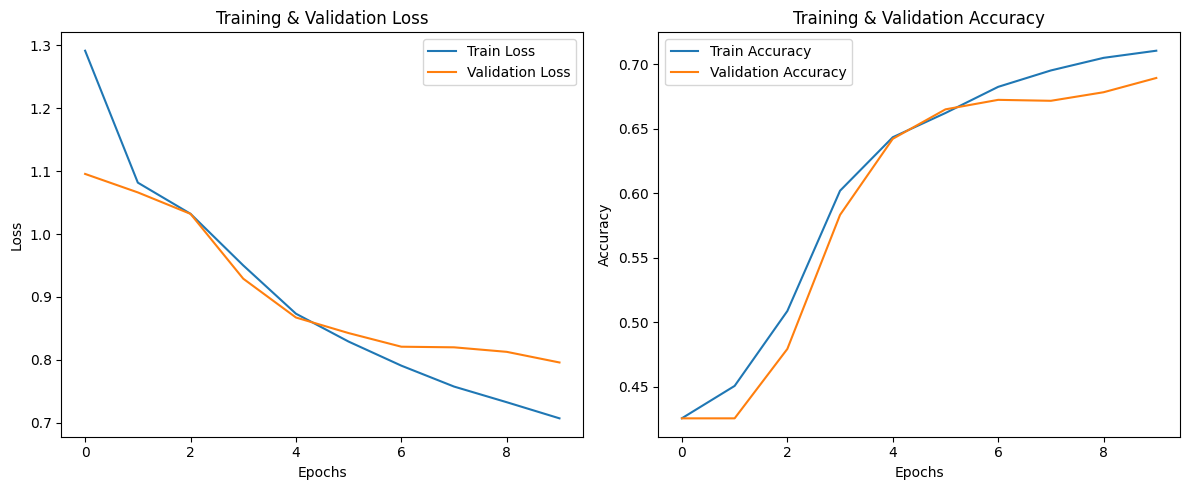

In [20]:
# Evaluate model
y_pred1 = np.argmax(model1.predict(X_val1), axis=1)
y_val_labels1 = np.argmax(y_val1, axis=1)
print(classification_report(y_val_labels1, y_pred1, target_names=["Neutral", "Gender Abuse", "Explicit Language", "Both"]))

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [21]:

# Compute F1 score, precision, and recall
accuracy = accuracy_score(y_val_labels1, y_pred1)
f1 = f1_score(y_val_labels1, y_pred1, average='macro')
precision = precision_score(y_val_labels1, y_pred1, average='macro')
recall = recall_score(y_val_labels1, y_pred1, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.68952802359882
F1 Score: 0.38839040449579565
Precision: 0.3505120798319328
Recall: 0.4386184036915791


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


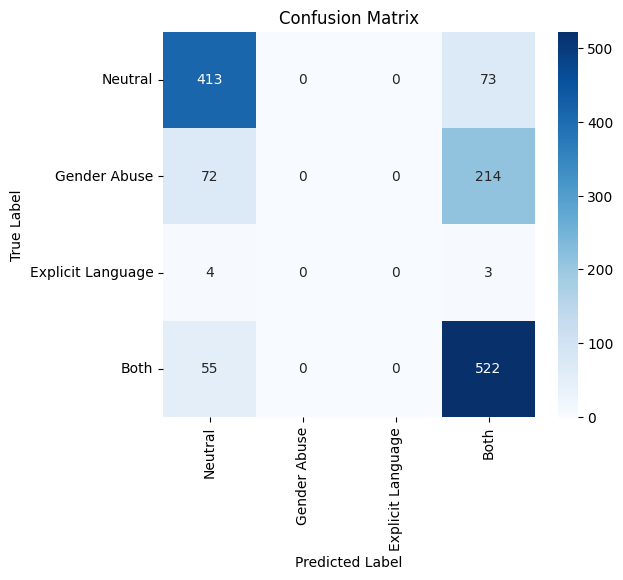

In [22]:
# Compute confusion matrix
cm = confusion_matrix(y_val_labels1, y_pred1)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neutral", "Gender Abuse", "Explicit Language", "Both"], yticklabels=["Neutral", "Gender Abuse", "Explicit Language", "Both"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Testing


In [23]:

sequence1 = tokenizer1.texts_to_sequences(dn_test.text)
sequence1 = pad_sequences(sequence1, padding='post', maxlen=max_len)

predictions1 = model1.predict(sequence1)
classes1 = np.argmax(predictions1, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [24]:
predictions1

print(len(predictions1))

1135


In [25]:
predictions1 = np.argmax(predictions1, axis=1)
print(predictions1)

[3 3 0 ... 3 0 3]


In [26]:
true_1 = dn_test["label"]
y_test_1 = true_1.values

print(y_test_1)
print(len(y_test_1))

[0 3 1 ... 3 3 3]
1135


In [27]:
ids = np.arange(1, len(y_test_1)+1)
result_df_1 = pd.DataFrame({'id': ids, 'prediction': predictions1, 'true': y_test_1})

In [28]:
def compute_metrics(result_df, color):
    # Compute metrics
    accuracy = accuracy_score(result_df['true'], result_df['prediction'])
    f1 = f1_score(result_df['true'], result_df['prediction'], average='macro')  # Use 'macro', 'micro', or 'weighted' as needed
    recall = recall_score(result_df['true'], result_df['prediction'], average='macro')
    precision = precision_score(result_df['true'], result_df['prediction'], average='macro')
    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix)

    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color, xticklabels=set(result_df['true']), yticklabels=set(result_df['true']))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 0.7709
F1 Score: 0.3996
Recall: 0.4514
Precision: 0.3689


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


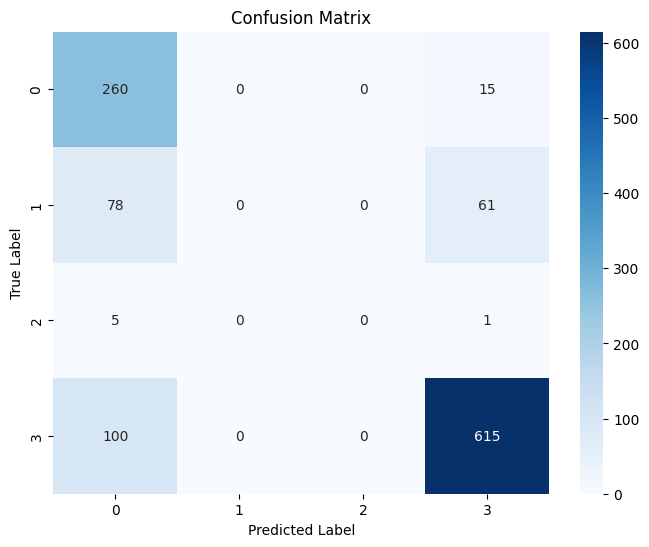

In [29]:
compute_metrics(result_df_1, "Blues")